# Geometric Tensor Completion



----------------

Geometric Tensor Completion (GTC) without the low-rank assumption is a machine learning model for reconstructing missing values within tensors. In particular, this model can use the graph regularizer (e.g., adjacent smoothness matrix based penalty in this study) to express side information.


## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

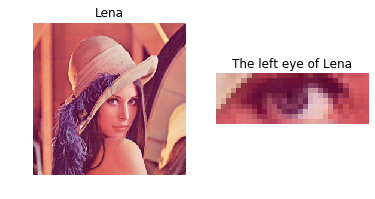

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('data/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye.

## Selected Images

We carry out our image inpainting experiments on the images of `Lena` and `Peppers`.

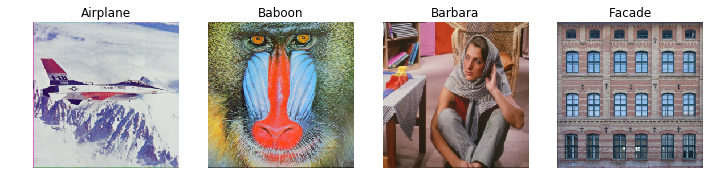

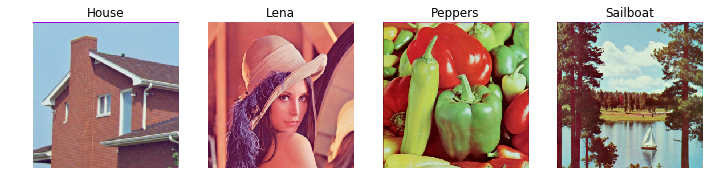

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Tensor Completion

### Preparation

We start by importing the necessary dependencies, and the following defined functions only make use of `numpy`.

In [4]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

Functions for unfolding a tensor into a matrix (`ten2mat`) and folding a matrix into a tensor (`mat2ten`) according to a specific mode:

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Main Function

In [7]:
def GTC(dense_tensor, sparse_tensor, beta, rho, maxiter):
    """Main function of the GTC."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[np.where(sparse_tensor != 0)] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = X[:, :, :, k] + T[:, :, :, k] / rho
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Experiments on Color Images

In the following, we illustrate the performance of image inpainting tasks using GTC on some color images.

We set the missing patterns as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we carry out the experiment on each image at each specific missing rate for 50 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

Here, it is convenient to import the image under a certain missing pattern at the 50% missing rate. For example, on the image `Lena`, we could choose

- `lena_mar`
- `lena_rmar`
- `lena_cmar`
- `lena_rcmar`

In [8]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [9]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GTC(image, sparse_image, beta, rho, maxiter)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GTC_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

6.890684769159697


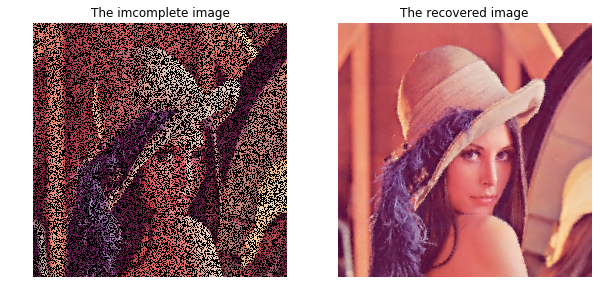

In [10]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using GTC:

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     6.89      |       8.20     |   10.80   |      8.38      |
|**peppers**|     7.97      |      11.02     |   11.88   |      9.60      |


### Whole Performance

We choose the images of `lena` and `peppers` for evaluation.

#### MAR (Missing at random)

In [11]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [12]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[6.16304847 6.96233193 8.19690579]
 [6.85059731 7.91580742 9.61462188]]

[[0.06447948 0.06769313 0.09257182]
 [0.08120758 0.07521665 0.10519193]]



#### R-MAR (Row-wise missing at random)

In [13]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [14]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 7.18051911  8.8501311  13.59722028]
 [ 9.38678027 11.32709493 16.4387813 ]]

[[0.46300916 1.82724723 3.90990989]
 [0.81321353 0.87502977 3.52729848]]



#### C-MAR (Column-wise missing at random)

In [15]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [16]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 8.54238705 10.05250286 15.07458762]
 [ 9.70611437 11.51142031 17.54190573]]

[[0.65991924 1.10302634 2.72450519]
 [0.85404233 0.94595866 3.50014299]]



#### RC-MAR ((Row, column)-wise missing at random)

In [17]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [18]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[ 7.40481549  8.35904961 10.13456227]
 [ 8.95352264 10.07211466 12.18707278]]

[[0.42155695 0.39933358 0.59958416]
 [0.85709519 0.5848021  0.60552502]]



Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using GTC:

|    -      | Scenario  |      MAR       |     R-MAR      |      C-MAR     |     RC-MAR     |
|:----------|:----------|---------------:|---------------:|---------------:|---------------:|
|  **Lena** | **30%**   | 6.16 $\pm$ 0.06| 7.18 $\pm$ 0.46| 8.54 $\pm$ 0.66| 7.40 $\pm$ 0.42|
|       -   | **50%**   | 6.96 $\pm$ 0.07| 8.85 $\pm$ 1.83|10.05 $\pm$ 1.10| 8.36 $\pm$ 0.40|
|       -   | **70%**   | 8.20 $\pm$ 0.09|13.60 $\pm$ 3.91|15.07 $\pm$ 2.72|10.13 $\pm$ 0.60|
|**Peppers**| **30%**   | 6.85 $\pm$ 0.08| 9.39 $\pm$ 0.81| 9.71 $\pm$ 0.85| 8.95 $\pm$ 0.86|
|       -   | **50%**   | 7.92 $\pm$ 0.08|11.33 $\pm$ 0.88|11.51 $\pm$ 0.95|10.07 $\pm$ 0.58|
|       -   | **70%**   | 9.61 $\pm$ 0.11|16.44 $\pm$ 3.53|17.54 $\pm$ 3.50|12.19 $\pm$ 0.61|